# RE-Free Materials Machine Learning Pipeline

# 0. Preparation

Install required libraries (scikit-learn and specific pandas version)

In [ ]:
!pip install scikit-learn==1.7.2
!pip install pandas==2.2.2
!pip install pymatgen==2025.10.7

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 36.0 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.6/55.6 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.9/119.9 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 809.1/809.1 kB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 788.2/788.2 kB 35.5 MB/s eta 0:00:00
  Created wheel for bibtexparser: filename=bibtexparser-1.4.3-py3-none

Download the required files

In [ ]:
!rm -rf magnetic-material-data
!rm -rf Novamag_Data_Files

In [ ]:
!git clone https://github.com/xianyuanliu/magnetic-material-data.git
!mv magnetic-material-data/data/* .
!rm -rf magnetic-material-data

Cloning into 'magnetic-material-data'...
remote: Enumerating objects: 6784, done.
remote: Total 6784 (delta 0), reused 0 (delta 0), pack-reused 6784 (from 2)
Receiving objects: 100% (6784/6784), 133.06 MiB | 32.45 MiB/s, done.
Resolving deltas: 100% (4085/4085), done.
Updating files: 100% (6741/6741), done.


Import dependency libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import alloys as al
import shap
import re

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance

from itertools import product

/home/xianyuan/anaconda3/envs/magmat/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. Data Preprocessing

Import the database. Please ignore the outputs warning about potential deprecated functions.

In [ ]:
PT = al.import_periodic_table("./Periodic-table/periodic_table.xlsx")
MM = al.import_miedema_weight("./Miedema-model/Miedema-model-reduced.xlsx")
X = al.importNovamag('./Novamag_Data_Files/')

Found directory: ./Novamag_Data_Files/
Found directory: ./Novamag_Data_Files/ICCRAM_UBU
Found directory: ./Novamag_Data_Files/ICCRAM_UBU/ASD
Found directory: ./Novamag_Data_Files/ICCRAM_UBU/ASD/MnAl_ASD
Found directory: ./Novamag_Data_Files/ICCRAM_UBU/ASD/FeNi_ASD
Found directory: ./Novamag_Data_Files/ICCRAM_UBU/AGA
Found directory: ./Novamag_Data_Files/ICCRAM_UBU/AGA/Fe-C
Found directory: ./Novamag_Data_Files/ICCRAM_UBU/AGA/Fe-C/4-1
Found directory: ./Novamag_Data_Files/ICCRAM_UBU/AGA/Fe-C/2-1
Found directory: ./Novamag_Data_Files/ICCRAM_UBU/AGA/Fe-C/5-1
Found directory: ./Novamag_Data_Files/ICCRAM_UBU/AGA/Fe-Sc
Found directory: ./Novamag_Data_Files/ICCRAM_UBU/AGA/Fe-Sc/4-1
Found directory: ./Novamag_Data_Files/ICCRAM_UBU/AGA/Fe-Sc/2-1
Found directory: ./Novamag_Data_Files/ICCRAM_UBU/AGA/Fe-Sc/3-1
Found directory: ./Novamag_Data_Files/ICCRAM_UBU/AGA/Fe-Sc/5-1
Found directory: ./Novamag_Data_Files/ICCRAM_UBU/AGA/Fe-Sc/3-2
Found directory: ./Novamag_Data_Files/ICCRAM_UBU/AGA/Fe-Sc/6-1
F

Clean the data to remove useless values

In [ ]:
print('The total number of imported features is {0}'.format(len(X.columns)))

# Fix the 'none' values
X = X.fillna(value=np.nan).copy()

# Find columns with missing values
na_cols = [col for col in X.columns if X[col].isna().any()]
print('The number of features with at least one NaN value is {0}'.format(
                                                              len(na_cols)))

# Extract chemical formula and target columns
X = X[['chemical formula', 'saturation magnetization']]
X['chemical formula'] = X['chemical formula'].astype(str)
X

The total number of imported features is 32
The number of features with at least one NaN value is 30


/tmp/ipython-input-1654628321.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X = X.fillna(value=np.nan).copy()


,chemical formula,saturation magnetization
0,Al1Mn1,1.010000
1,Fe1Ni1,1.710000
2,Fe8C2,1.888000
3,Fe4C1,1.793000
4,Fe4C1,1.875000
...,...,...
1657,Sc8Co4Ir4,0.045667
1658,Al8Fe16,1.095260
1659,Y8Ni16,0.000060
1660,Nb4Cr4W4,0.236499


Plot a Histogram of Ms distribution for TM elements

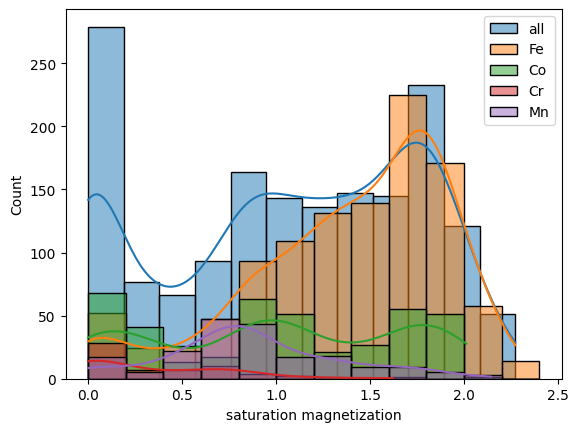

In [ ]:
# Make some sub-datasets grouped by elements
X_Fe = X[X['chemical formula'].str.contains(pat='Fe')]
X_Co = X[X['chemical formula'].str.contains(pat='Co')]
X_Cr = X[X['chemical formula'].str.contains(pat='Cr')]
X_Mn = X[X['chemical formula'].str.contains(pat='Mn')]

plt.figure()
bins = np.arange(0, 2.6, 0.2) #bins arranged from 0-2.6 with a different one at 0.2 increments

sns.histplot(data=X['saturation magnetization'], kde = True, label = 'all')
sns.histplot(data=X_Fe['saturation magnetization'], kde=True, bins=bins, label='Fe')
sns.histplot(data=X_Co['saturation magnetization'], kde=True, bins=bins, label='Co')
sns.histplot(data=X_Cr['saturation magnetization'], kde=True, bins=bins, label='Cr')
sns.histplot(data=X_Mn['saturation magnetization'], kde=True, bins=bins, label='Mn')
plt.legend()

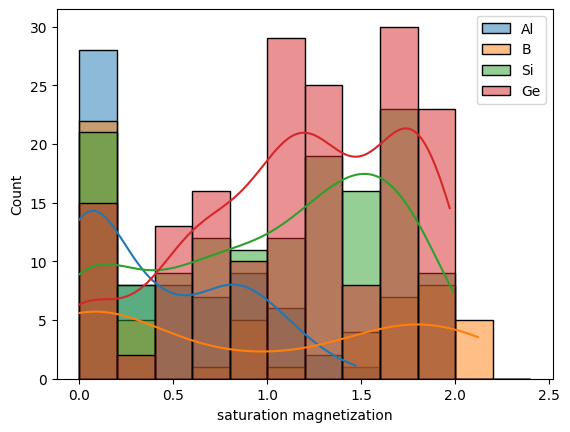

In [ ]:
# Make some sub-datasets grouped by elements
X_Al = X[X['chemical formula'].str.contains(pat='Al')]
X_B = X[X['chemical formula'].str.contains(pat='B')]
X_Si = X[X['chemical formula'].str.contains(pat='Si')]
X_Ge = X[X['chemical formula'].str.contains(pat='Ge')]

plt.figure()
bins = np.arange(0, 2.6, 0.2) #bins arranged from 0-2.6 with a different one at 0.2 increments

sns.histplot(data=X_Al['saturation magnetization'], kde=True, bins=bins, label='Al')
sns.histplot(data=X_B['saturation magnetization'], kde=True, bins=bins, label='B')
sns.histplot(data=X_Si['saturation magnetization'], kde=True, bins=bins, label='Si')
sns.histplot(data=X_Ge['saturation magnetization'], kde=True, bins=bins, label='Ge')
plt.legend()

Plot a Violin Plot of Ms distribution for TM elements

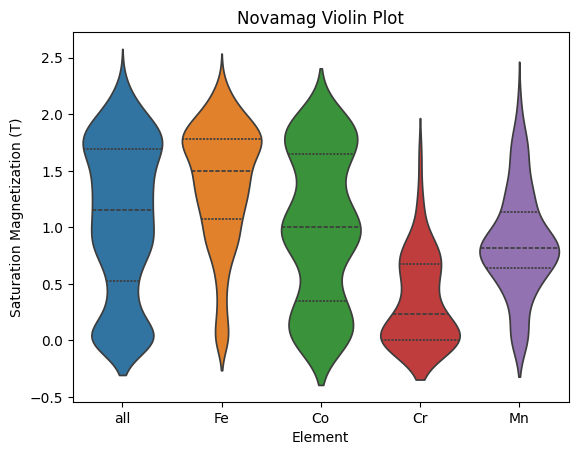

In [ ]:
# Make some sub-datasets grouped by elements
X_Fe = X[X['chemical formula'].str.contains(pat='Fe')]
X_Co = X[X['chemical formula'].str.contains(pat='Co')]
X_Cr = X[X['chemical formula'].str.contains(pat='Cr')]
X_Mn = X[X['chemical formula'].str.contains(pat='Mn')]

# Combine all sub-datasets into a single DataFrame
data = pd.concat([X['saturation magnetization'].rename('all'),
                  X_Fe['saturation magnetization'].rename('Fe'),
                  X_Co['saturation magnetization'].rename('Co'),
                  X_Cr['saturation magnetization'].rename('Cr'),
                  X_Mn['saturation magnetization'].rename('Mn')], axis=1)

# Plotting violin plot
plt.figure()
sns.violinplot(data=data, inner="quartile")
plt.xlabel('Element')
plt.ylabel('Saturation Magnetization (T)')
plt.title('Novamag Violin Plot')
plt.show()

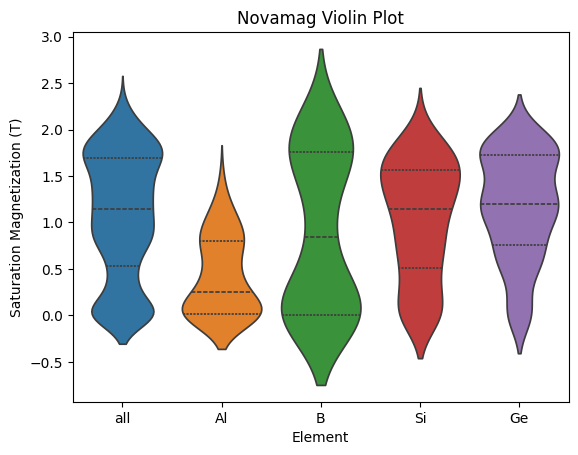

In [ ]:
# Make some sub-datasets grouped by elements
X_Al = X[X['chemical formula'].str.contains(pat='Al')]
X_B = X[X['chemical formula'].str.contains(pat='B')]
X_Si = X[X['chemical formula'].str.contains(pat='Si')]
X_Ge = X[X['chemical formula'].str.contains(pat='Ge')]

# Combine all sub-datasets into a single DataFrame
data = pd.concat([X['saturation magnetization'].rename('all'),
                  X_Al['saturation magnetization'].rename('Al'),
                  X_B['saturation magnetization'].rename('B'),
                  X_Si['saturation magnetization'].rename('Si'),
                  X_Ge['saturation magnetization'].rename('Ge')], axis=1)

# Plotting violin plot
plt.figure()
sns.violinplot(data=data, inner="quartile")
plt.xlabel('Element')
plt.ylabel('Saturation Magnetization (T)')
plt.title('Novamag Violin Plot')
plt.show()

Build features based on the stoichiometric array from relevant commands from the alloys module

Please ignore the outputs again

In [ ]:
stoich_array = al.get_stoich_array(X, PT)

X['stoicentw'] = al.get_StoicEntw(stoich_array)  # Stoicheometry weighted mixing entropy
X['Zw'] = al.get_Zw(PT, stoich_array)           # Stoicheometry weighted atomic mass
# X['compoundradix'] = al.get_CompoundRadix(PT, X)  # Compound radix, i.e. binary, ternary, quaternary...
X['periodw'] = al.get_Periodw(PT, stoich_array)   # Stoicheometry weighted periodic table period
X['groupw'] = al.get_Groupw(PT, stoich_array)   # Stoicheometry weighted periodic table group
X['meltingTw'] = al.get_MeltingTw(PT, stoich_array) # Stoicheometry weighted melting point
X['miedemaH'] = al.get_Miedemaw(MM, stoich_array) # Stoicheometry weighted Miedema enthalpy of mixing
X['valencew'] = al.get_Valencew(PT, stoich_array) # Stoicheometry weighted valency
X['electronegw'] = al.get_Electronegw(PT, stoich_array) # Stoicheometry weighted electronegativity
print('Finished')

Finished


clean data to address the issues raised by the previous data preprocessing steps

In [ ]:
my_cols = ['stoicentw',
           'Zw',
           'periodw',
           'groupw',
           'meltingTw',
           'miedemaH',
           'valencew',
           'electronegw']

# Remove rows with missing target, separate target from predictors
X.dropna(axis=0, subset=['saturation magnetization'] + my_cols, inplace=True)

# Drop alloys which are below magnetic cutoff (determined through prior model optimisation)
X.drop(X[X['saturation magnetization'] < 0.18].index, axis=0, inplace=True)

# Round the saturation magnetization to 1.d.p
X['saturation magnetization'] = pd.to_numeric(
    X['saturation magnetization']).round(decimals=2)

# Group duplicates by chemical formula and replace values with median
X = X.groupby(by='chemical formula').median()
X.index = range(len(X))

# Define the target as the series 'y' and drop this from the dataframe 'X'.
y = X['saturation magnetization']
X.drop(['saturation magnetization'], axis=1, inplace=True)

Split database to training and test set

In [ ]:
train_size = 0.8
# Break off validation set from training data
X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                      train_size=train_size,
                                                      test_size=1-train_size,
                                                      random_state=0)
X_train = X_train[my_cols].copy()
X_valid = X_valid[my_cols].copy()

# 2. Model Design - Linear Regression

## *Hyperparameter Optimisation*
Search the optimised hyperparameters for fit_intecept and positive

- fit_intercept = whether to calculate the intercept for this model
- positive = whether to constrain the coefficients non-negative



In [ ]:
from sklearn.linear_model import LinearRegression

# Define the parameter grid to search
param_grid = {
    'fit_intercept': [True, False],
    'positive': [True, False],
}

# Create a Linear Regression model
lr_model = LinearRegression()

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=lr_model, param_grid=param_grid,
                           cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score (neg_mean_squared_error):", best_score)

Best Parameters: {'fit_intercept': False, 'positive': False}
Best Score (neg_mean_squared_error): -0.13916983999275517


## *Model Training with Optimised Hyperparameters*

In [ ]:
lr_model = LinearRegression(fit_intercept=False, copy_X=True, positive=False)

In [ ]:
lr_model.fit(X_train, y_train)
lrpreds = lr_model.predict(X_valid)

# 3. Evaluation/Prediction - Quantitative Evaluation


## *Mean Squared Error*

In [ ]:
lr_mse = mean_squared_error(y_valid, lrpreds)

print("Mean Squared Error (MAE):")
print("Linear Regression:", lr_mse)

Mean Squared Error (MAE):
Linear Regression: 0.10250768335511103


## *Mean Absolute Error*

In [ ]:
lr_mae = mean_absolute_error(y_valid, lrpreds)

print("Mean Absolute Error (MAE):")
print("Linear Regression:", lr_mae)

Mean Absolute Error (MAE):
Linear Regression: 0.2599311879725782


## *R2 Score*

In [ ]:
lr_r2 = r2_score(y_valid, lrpreds)

print("R-squared (R2) Score:")
print("Linear Regression:", lr_r2)

R-squared (R2) Score:
Linear Regression: 0.6181079390255523


# 4. Feature Importance
Explore the relationship between inputs and output

## *Permutation Feature Importance*

A model-agnostic method that evaluates the importance of a feature by measuring the change in a model's performance when the feature's values are randomly shuffled

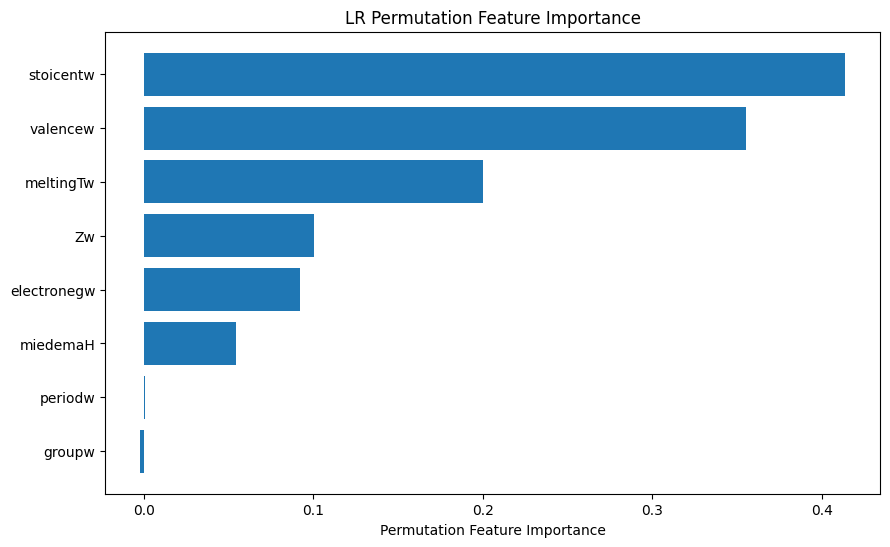

In [ ]:
lr_model.fit(X_train, y_train)

perm_importance = permutation_importance(lr_model, X_valid, y_valid, n_repeats=10, random_state=0)

sorted_idx = perm_importance.importances_mean.argsort()

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), X_valid.columns[sorted_idx])
plt.xlabel('Permutation Feature Importance')
plt.title('LR Permutation Feature Importance')
plt.show()

## *SHAP Feature Importance*

A method based on Shapley values from game theory, which quantifies the contribution of each feature to a model's predictions by fairly distributing the output among all features

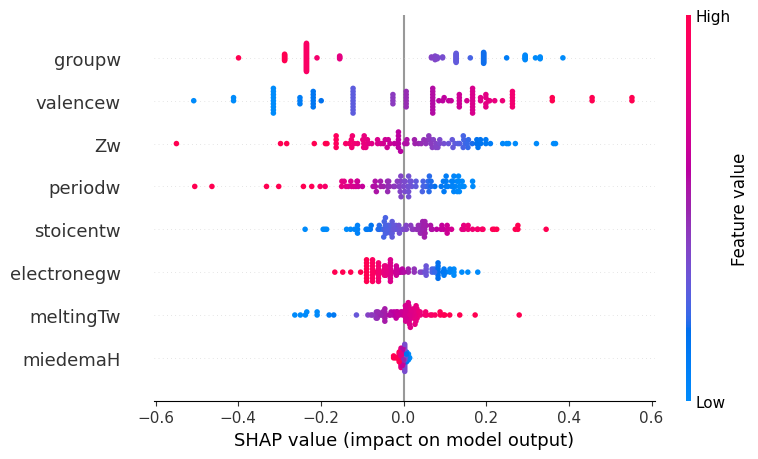

In [ ]:
explainer = shap.Explainer(lr_model, X_train)
shap_values = explainer(X_valid)

shap.summary_plot(shap_values, X_valid, feature_names=X_valid.columns[sorted_idx])
plt.show()